In [214]:
import numpy as np
import pandas as pd
from scipy.stats.mstats import winsorize
from sklearn.linear_model import Lasso,LassoCV,LassoLarsCV
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

from sklearn import svm
from sklearn.tree import DecisionTreeClassifier,plot_tree
import pickle
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from scipy.stats.mstats import winsorize
import seaborn as sns

In [215]:
def AUC_metric(df):
    auc = np.sum(df['pred'] == df['label']) / len(df)
    return auc

# Load data

In [216]:
def load_data(path):
    df_train = pd.read_csv(f'{path}/cs-training.csv',index_col=0)
    df_test = pd.read_csv(f'{path}/cs-test.csv',index_col=0)
    df_subm = pd.read_csv(f'{path}/sampleEntry.csv',index_col=0)
    df_describe = pd.read_excel(f'{path}/Data Dictionary.xls',header=1)
    return df_train, df_test, df_subm, df_describe

In [217]:
df_train, df_test, df_subm, df_describe = load_data(path='./data')

In [218]:
df_describe

,Variable Name,Description,Type
0,SeriousDlqin2yrs,Person experienced 90 days past due delinquenc...,Y/N
1,RevolvingUtilizationOfUnsecuredLines,Total balance on credit cards and personal lin...,percentage
2,age,Age of borrower in years,integer
3,NumberOfTime30-59DaysPastDueNotWorse,Number of times borrower has been 30-59 days p...,integer
4,DebtRatio,"Monthly debt payments, alimony,living costs di...",percentage
5,MonthlyIncome,Monthly income,real
6,NumberOfOpenCreditLinesAndLoans,Number of Open loans (installment like car loa...,integer
7,NumberOfTimes90DaysLate,Number of times borrower has been 90 days or m...,integer
8,NumberRealEstateLoansOrLines,Number of mortgage and real estate loans inclu...,integer
9,NumberOfTime60-89DaysPastDueNotWorse,Number of times borrower has been 60-89 days p...,integer


In [219]:
df_train.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


# Feature Engineer

## Combine data

In [220]:
# set features and label
label = df_describe.loc[0,'Variable Name']
features = df_describe.loc[1:,'Variable Name'].to_list()

In [221]:
# set flag to classify train data and test data
df_train['istest'] = 0
df_test['istest'] = 1

In [222]:
# combine train data and test data, and process it
df_raw = pd.concat([df_train,df_test],axis=0)

In [223]:
df_raw[features] = df_raw[features].fillna(0)

F:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='NumberOfTime30-59DaysPastDueNotWorse', ylabel='Density'>

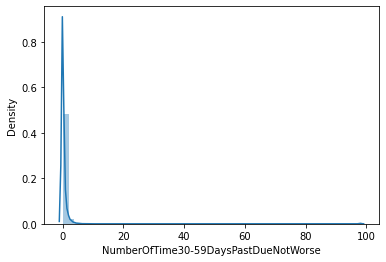

In [224]:
sns.distplot(df_raw['NumberOfTime30-59DaysPastDueNotWorse'])

## Winsorize Outlier

In [225]:
for feat in features:
    df_raw[feat] = winsorize(df_raw[feat],limits=[0.01,0.01])

## Normalized Feature

In [226]:
df_raw.loc[:,features] = (df_raw.loc[:,features] - df_raw.loc[:,features].mean(axis=0)) / df_raw.loc[:,features].std(axis=0)

## Lasso Feature Selection

In [227]:
def Lasso_select_features(df_raw,features,label):
    lasso_model = Lasso(alpha=0.064)
    X_train = df_raw.loc[df_raw['istest']==0,features]
    Y_train = df_raw.loc[df_raw['istest']==0,label]
    lasso_model.fit(X_train,Y_train)
    print(lasso_model.coef_)
    select_features = list(np.array(features)[lasso_model.coef_!=0])
    
    return select_features

In [228]:
select_features = Lasso_select_features(df_raw,features,label)

[ 0.         -0.          0.00087344 -0.         -0.         -0.
  0.0226296  -0.          0.          0.        ]


In [229]:
select_features

['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate']

# Train Model

In [230]:
def valid_metric(Model,Model_name,x_valid,y_valid,i):
    y_pred = Model.predict_proba(x_valid)[:,1]
#     df = pd.DataFrame({'pred':y_pred,'label':y_valid})
    
    auc_val = roc_auc_score(y_valid, y_pred)
    print(f'fold{i+1}: {Model_name} vaild AUC {round(auc_val,4)}')

def save_model(Model,Model_name,i,path):
    os.makedirs(path,exist_ok=True)
    with open(f'{path}/{Model_name}_{i}.pkl','wb') as f:
        pickle.dump(Model,f)

def load_model(Model_name,i,path):
    with open(f'{path}/{Model_name}_{i}.pkl','rb') as f:
        model = pickle.load(f)
    return model 
    

In [240]:
# kfolds cross validation
kfolds = KFold(n_splits=5, shuffle=False)
train_data = df_raw[df_raw['istest']==0]
train_data = train_data.reset_index().drop('index',axis=1)

LR_Model_list = []
SVM_Model_list = []
Tree_Model_list = []

for i,(train_idx, val_idx) in enumerate(kfolds.split(train_data)):
    # Split train and valid
    x_train = train_data.loc[train_idx,select_features].values
    y_train = train_data.loc[train_idx,label].values
    
    x_valid = train_data.loc[val_idx,select_features].values
    y_valid = train_data.loc[val_idx,label].values
    
    # Logistic Model
    LR_Model = LogisticRegression()
    LR_Model.fit(x_train, y_train)
    save_model(LR_Model,'LogisticRegression',i+1,path='./saved_model') # save model
    
    valid_metric(Model=LR_Model,Model_name='LogisticRegression',x_valid=x_valid,y_valid=y_valid,i=i)
    
    
#     # SVM Model
#     SVM_Model = svm.SVC(kernel = 'linear',probability=True)
#     SVM_Model.fit(x_train, y_train)
#     save_model(SVM_Model,'SVM',i+1,path='./saved_model') # save model
    
#     valid_metric(Model=SVM_Model,Model_name='SVM',x_valid=x_valid,y_valid=y_valid,i=i)
    

    # Tree Model
    DecisonTree_Model = DecisionTreeClassifier(min_samples_leaf=10)
    DecisonTree_Model.fit(x_train, y_train)
    
    save_model(DecisonTree_Model,'DecisionTree',i+1,path='./saved_model') # save model
    
    valid_metric(Model=DecisonTree_Model,Model_name='DecisionTree',x_valid=x_valid,y_valid=y_valid,i=i)
    
    
    
    

fold1: LogisticRegression vaild AUC 0.7538
fold1: DecisionTree vaild AUC 0.7545
fold2: LogisticRegression vaild AUC 0.7568
fold2: DecisionTree vaild AUC 0.7575
fold3: LogisticRegression vaild AUC 0.7601
fold3: DecisionTree vaild AUC 0.7607
fold4: LogisticRegression vaild AUC 0.7561
fold4: DecisionTree vaild AUC 0.7563
fold5: LogisticRegression vaild AUC 0.7647
fold5: DecisionTree vaild AUC 0.7656


In [236]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# To check recent matplotlib compatibility
import matplotlib
from distutils.version import LooseVersion


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    color=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]

        
        if LooseVersion(matplotlib.__version__) < LooseVersion('0.3.4'):
            plt.scatter(X_test[:, 0],
                        X_test[:, 1],
                        c='',
                        edgecolor='black',
                        alpha=1.0,
                        linewidth=1,
                        marker='o',
                        s=100, 
                        label='test set')
        else:
            plt.scatter(X_test[:, 0],
                        X_test[:, 1],
                        c='none',
                        edgecolor='black',
                        alpha=1.0,
                        linewidth=1,
                        marker='o',
                        s=100, 
                        label='test set')        

F:\Anaconda\lib\site-packages\ipykernel_launcher.py:34: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


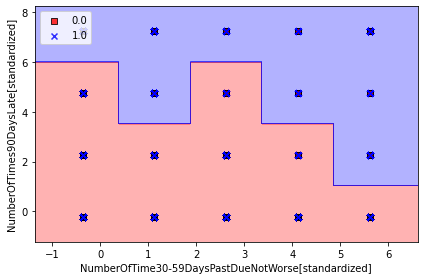

In [243]:
plot_decision_regions(X=x_train, y=y_train,
                      classifier=DecisonTree_Model)
plt.xlabel(f'{select_features[0]}[standardized]')
plt.ylabel(f'{select_features[1]}[standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('images/03_01.png', dpi=300)
plt.show()

# Predict

In [244]:
x_test = df_test.loc[:,select_features].values
y_test = df_test.loc[:,label].values

In [245]:
pred_prob = 0
for i in range(1,6):
    LR_model = load_model('LogisticRegression',i,path='./saved_model')
    pred_prob += LR_model.predict_proba(x_test)
    Tree_model = load_model('DecisionTree',i,path='./saved_model')
    pred_prob += Tree_model.predict_proba(x_test)

pred_prob = pred_prob / 10

In [206]:
df_subm1 = df_subm.copy()

In [207]:
df_subm1['Probability'] = pred_prob[:,1]

In [208]:
df_subm1

,Probability
Id,
1,0.040674
2,0.040674
3,0.040674
4,0.093339
5,0.040674
...,...
101499,0.040674
101500,0.186883
101501,0.040674


In [209]:
df_subm1.to_csv('./df_subm1.csv')

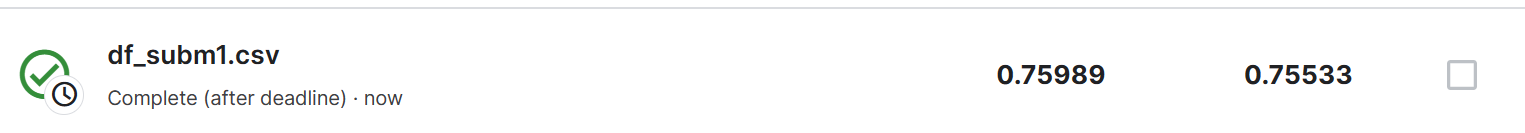